# Variational Inference with classical posterior

In this notebook we set the VI loss to be the negative log-likelihood, to recover the classical posterior.

In [1]:
from blackbirds.models.random_walk import RandomWalk
from blackbirds.infer.vi import VI
from blackbirds.posterior_estimators import TrainableGaussian
from blackbirds.simulate import simulate_and_observe_model

import torch
import math
import matplotlib.pyplot as plt
import pandas as pd

In [65]:
rw = RandomWalk(n_timesteps=40)

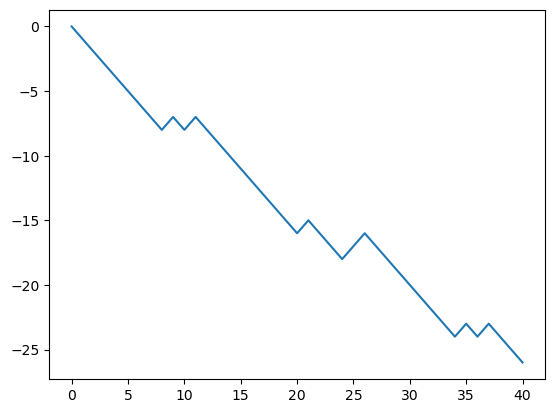

In [66]:
true_p = torch.logit(torch.tensor(0.25))
data = rw.run_and_observe(torch.tensor([true_p]))

plt.plot(data[0].numpy())

In [67]:
class LogLikelihoodLoss:
    def __init__(self, model):
        self.model = model
        self.loss_fn = torch.nn.MSELoss()
        
    def __call__(self, params, data):
        N = self.model.n_timesteps
        p = torch.sigmoid(params[0])
        lp = 0
        for n in range(1, N+1):
            k = int(data[0][n].item())
            likelihood = math.comb(n, (n+k)//2) * p**((n+k)//2) * (1-p)**((n-k)//2)
            lp += likelihood.log()
        return -lp

In [74]:
posterior_estimator = TrainableGaussian([0.], 1.0)
prior = torch.distributions.Normal(true_p + 0.1, 0.1)
optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-2)
ll = LogLikelihoodLoss(rw)

vi = VI(ll, posterior_estimator=posterior_estimator, prior=prior, data=data, optimizer=optimizer, w = 1.0, n_samples_regularisation=1000)

In [75]:
# we can now train the estimator for a 100 epochs
vi.run(1000, max_epochs_without_improvement=100)

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 516/1000 [00:32<00:30, 15.87it/s, loss=61.8, reg.=8.53, total=70.4, best loss=60.6, epochs since improv.=100]


<Axes: >

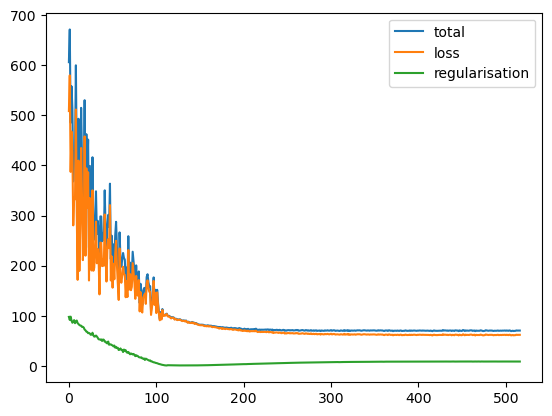

In [76]:
df = pd.DataFrame(vi.losses_hist)
df.plot()

In [77]:
# We can now load the best model
posterior_estimator.load_state_dict(vi.best_estimator_state_dict)

<All keys matched successfully>

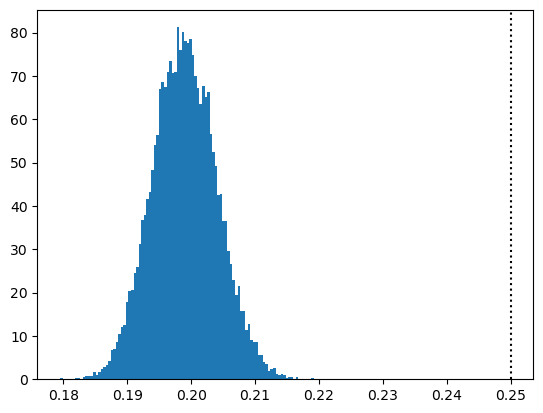

In [78]:
# and plot the posterior
with torch.no_grad():
    samples = posterior_estimator.sample(20000)[0].flatten().cpu()
plt.hist(torch.sigmoid(samples), density=True, bins=100);
plt.axvline(torch.sigmoid(true_p), label = "true value", color = "black", linestyle=":")

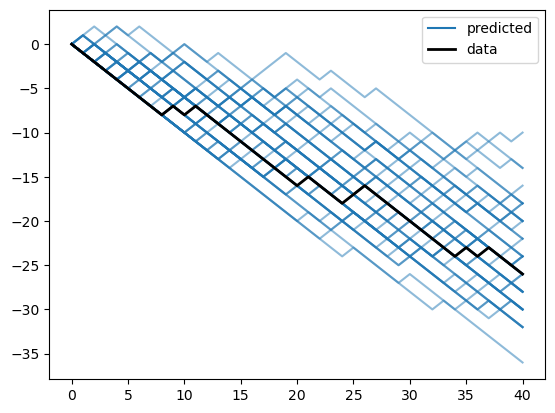

In [79]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(50):
    with torch.no_grad():
        sim_rw = rw.run_and_observe(posterior_estimator.sample(1)[0])[0].numpy()
    ax.plot(sim_rw, color = "C0", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted")
ax.plot(data[0], color = "black", linewidth=2, label = "data")

ax.legend()